# Use Tensorflow to recognize hand-written digits with `ibm-watsonx-ai`

This notebook facilitates Tensorflow and watsonx.ai service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository. It also introduces commands for getting model and training data, persisting model, deploying model and scoring it.

Some familiarity with Python is helpful. This notebook uses Python 3.12.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Tensorflow model with dataset.
-  Persist an external model in watsonx.ai repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Download externally created Tensorflow model and data](#download)
3. [Persist externally created Tensforflow model](#upload)
4. [Deploy and score](#deploy)
5. [Clean up](#cleanup)
6. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pak for Data administrator and ask them for your account credentials

### Install dependencies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [1]:
%pip install -U wget | tail -n 1
%pip install -U matplotlib | tail -n 1
%pip install -U ibm-watsonx-ai | tail -n 1

#### Define credentials

Authenticate the watsonx.ai Runtime service on IBM Cloud Pak for Data. You need to provide the **admin's** `username` and the platform `url`.

In [ ]:
username = "PASTE YOUR USERNAME HERE"
url = "PASTE THE PLATFORM URL HERE"

Use the **admin's** `api_key` to authenticate watsonx.ai Runtime services:

In [ ]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=getpass.getpass("Enter your watsonx.ai API key and hit enter: "),
    url=url,
    instance_id="openshift",
    version="5.2",
)

Alternatively you can use the **admin's** `password`:

In [3]:
import getpass
from ibm_watsonx_ai import Credentials

if "credentials" not in locals() or not credentials.api_key:
    credentials = Credentials(
        username=username,
        password=getpass.getpass("Enter your watsonx.ai password and hit enter: "),
        url=url,
        instance_id="openshift",
        version="5.2",
    )

#### Create `APIClient` instance

In [4]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watsonx-ai-samples/blob/master/cpd5.2/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [ ]:
space_id = "PASTE YOUR SPACE ID HERE"

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in watsonx.ai, you need to set **space** which you will be using.

In [6]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Download externally created Tensorflow model and data
In this section, you will download externally created Tensorflow models and data used for training it.

In [7]:
import os
import wget

data_dir = "MNIST_DATA"
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

model_path = os.path.join(data_dir, "mnist-tf-hpo-saved-model.tar.gz")
if not os.path.isfile(model_path):
    wget.download(
        "https://github.com/IBM/watsonx-ai-samples/raw/master/cpd5.2/models/tensorflow/mnist/mnist-tf-hpo-saved-model.tar.gz",
        out=data_dir,
    )

In [8]:
data_dir = "MNIST_DATA"
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

filename = os.path.join(data_dir, "mnist.npz")
if not os.path.isfile(filename):
    wget.download("https://s3.amazonaws.com/img-datasets/mnist.npz", out=data_dir)

In [9]:
import numpy as np

dataset = np.load(filename)
x_test = dataset["x_test"]

<a id="upload"></a>
## 3. Persist externally created Tensorflow model

In this section, you will learn how to store your model in watsonx.ai repository by using the IBM watsonx.ai SDK.

### 3.1: Publish model

#### Publish model in watsonx.ai repository on Cloud.

Define model name, autor name and email.

In [10]:
sofware_spec_id = client.software_specifications.get_id_by_name("runtime-25.1-py3.12")

In [11]:
metadata = {
    client.repository.ModelMetaNames.NAME: "External Tensorflow model",
    client.repository.ModelMetaNames.TYPE: "tensorflow_2.18",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sofware_spec_id,
}

published_model = client.repository.store_model(model=model_path, meta_props=metadata)

### 3.2: Get model details

In [12]:
import json

published_model_id = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_id)
print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "name": "External Tensorflow model",
    "space_id": "8a13841b-df99-4b4d-bf2a-161ad2e33980",
    "resource_key": "f8f48ec9-9d46-4782-b267-7d8349cc4c0e",
    "id": "11cfd96c-fcfa-42eb-9e53-c10e929eb722",
    "created_at": "2025-05-20T06:58:46Z",
    "rov": {
      "member_roles": {
        "1000331001": {
          "user_iam_id": "1000331001",
          "roles": [
            "OWNER"
          ]
        }
      }
    },
    "owner": "1000331001"
  },
  "entity": {
    "software_spec": {
      "id": "f47ae1c3-198e-5718-b59d-2ea471561e9e"
    },
    "type": "tensorflow_2.18"
  }
}


### 3.3 Get all models

In [13]:
models_details = client.repository.list_models()

<a id="deploy"></a>
## 4. Deploy and score

In this section you will learn how to create online scoring and to score a new data record by using the IBM watsonx.ai SDK.

### 4.1: Create model deployment

#### Create online deployment for published model

In [14]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Tensorflow model",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



######################################################################################

Synchronous deployment creation for id: '11cfd96c-fcfa-42eb-9e53-c10e929eb722' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.......
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='71a746ff-ce9d-4938-a01a-f4045f81e35c'
-----------------------------------------------------------------------------------------------




**Note**: Here we use deployment URL saved in `published_model` object. In next section, we show how to retrieve deployment URL from watsonx.ai instance.

In [15]:
deployment_id = client.deployments.get_id(created_deployment)

Now you can print an online scoring endpoint. 

In [ ]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

You can also list existing deployments.

In [17]:
client.deployments.list()

,ID,NAME,STATE,CREATED,ARTIFACT_TYPE,SPEC_STATE,SPEC_REPLACEMENT
0,71a746ff-ce9d-4938-a01a-f4045f81e35c,Deployment of external Tensorflow model,ready,2025-05-20T06:59:06.155Z,model,supported,


### 4.2: Get deployment details

In [ ]:
client.deployments.get_details(deployment_id)

<a id="score"></a>
### 4.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

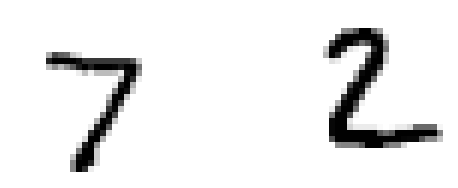

In [20]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis("off")
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

Prepare scoring payload with records to score.

In [21]:
score_0 = x_test[0].flatten().tolist()
score_1 = x_test[1].flatten().tolist()

In [22]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [23]:
predictions = client.deployments.score(deployment_id, scoring_payload)

Let's print the result of predictions.

In [24]:
import json

print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "classes",
      "values": [
        7,
        2
      ]
    }
  ]
}


As you can see, predicted values are the same one as displayed above from test dataset.

<a id="cleanup"></a>
## 5. Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watsonx-ai-samples/blob/master/cpd5.2/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

You successfully completed this notebook! You learned how to use Tensorflow as well as watsonx.ai for model creation and deployment. 
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Daniel Ryszka**, Software Engineer

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.